In [26]:
import qiskit
qiskit.__version__

%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


# The HHL Algorithm

> We use a free quantum simulator provided by BlueQubit in order to run our quantum circuits. This is free up to 34 qubits. This is similar to IBM's Aer simulator, which essentially uses multiple classical processors in parallel to emulate quantum hardware with the help of some maths.

Let us take the linear system of equations represented as:

$$

A_{n\times n}\ket{x}_{n\times 1} = \ket{b}_{n\times 1}

$$

Classically HHL has four main steps:
1. State preparation
1. Quantum Phase Estimation (QPE)
1. Ancilla Rotation
1. Inverse QPE and measurement

How many qubits do we need for HHL?
- n qubits to represent the vector |b⟩
- m qubits for the eigenvalue register (QPE)
- 1 ancilla qubit for the controlled rotation

Thus the state ends up as:

$$

\ket{\phi} = \ket{0}^{n} \otimes \ket{0}^{m} \otimes \ket{0}_{a}

$$

## State Preparation

The HHL algorithm operates based on some assumptions.
- Probability of states should be normalized. Since any wavefunction's magnitude squared gives the probability density, it must sum up to 1. Hence to use the vectors as states, they must be normalized.
- The matrix A must be Hermitian. If it is not, we can convert it to a Hermitian matrix. It also promises to be sparse (mostly empty) and well-conditioned (having a low condition number - correlation between input and output is high).

Here, we need to embed the vector |b⟩ into a quantum state. This can be done using various methods, such as:
- Using rotation gates to set the amplitudes of the qubits. [Here we assume that such a rotation gate exists.]
- Using more advanced techniques like Grover-Rudolph method for larger vectors. [https://pennylane.ai/blog/2025/10/state-preparation]

Thus in the n qubits, we set them to represent the state |b⟩.

$$

U_b\ket{0}^{\otimes n} = \ket{b} = b_1\ket{00...0} + b_2\ket{00...1} + ... + b_{2^n}\ket{11...1}\\

\implies \ket{\phi_1} = \ket{b} \otimes \ket{0}^{m} \otimes \ket{0}_{a}

$$

## Quantum Phase Estimation (QPE)

In short, it is used to find the eigenvalue phases for the eigenvectors of a unitary operator. Here, we use it to find the eigenvalues of the matrix A. If we write the characteristic equation of an unitary matrix U as:

$$
U\ket{u} = e^{2\pi i \theta}\ket{u}
$$

Where |u⟩ is the eigenvector and θ is the eigenvalue phase. The QPE algorithm estimates θ. This is used to solve for the eigenvalues phases which are then stored in the m qubit register.

How? It has three main steps:
1. Apply Hadamard gates to the m qubits to create superposition.
2. Apply controlled-U operations where U is the unitary operator (here it is e^{iAt}) controlled by the m qubits.
3. Apply the Inverse Quantum Fourier Transform (IQFT) to the m qubits to extract the phase information.

### Step 1: Initialize in Superposition

Step 1 is simple. Similar to most algorithms, we initialize the qubits in superposition using Hadamard gates. This gives us the state:

$$

\ket{\phi_2} = \ket{b}_{n} \otimes \left(\frac{1}{2^{m/2}}\sum_{k=0}^{2^m-1}\ket{k}_{m}\right) \otimes \ket{0}_{a}

$$

### Step 2: Controlled Unitary Operations

Now, we try to apply the unitary operator $U = e^{iAt}$ controlled by the m qubits. Why this operator? Because it's phases have the eigenvalues of A. How?

$$

A\ket{u_j} = \lambda_j\ket{u_j} \implies U\ket{u_j} = e^{iAt}\ket{u_j} = e^{i\lambda_j t}\ket{u_j} = e^{2\pi i \theta_j}\ket{u_j}\\

\text{where } \theta_j = \frac{\lambda_j t}{2\pi}

$$

This gives us the eigenvalue phases $\theta_j$. Now, how do we apply controlled-U operations? We apply $U$, ${2^k}$ times controlled by the k-th qubit of the m qubit register. This means that for each qubit in the m register, we apply the unitary operator raised to the power of $2^k$.

$$

\ket{\phi_3} = \ket{b}_{n} \otimes \left(\frac{1}{2^{m/2}}\sum_{k=0}^{2^m-1}U^{2^k}\ket{k}_{m}\right) \otimes \ket{0}_{a}
\implies \ket{\phi_3} = \ket{b}_{n} \otimes \left(\frac{1}{2^{m/2}}\sum_{k=0}^{2^m-1}e^{2\pi i \theta_j k}\ket{k}_{m}\right) \otimes \ket{0}_{a}

$$

### Step 3: Inverse Quantum Fourier Transform (IQFT)

Notice that the m qubit register now contains the phase information in the amplitudes. To extract this information, we apply the Inverse Quantum Fourier Transform (IQFT) to the m qubits.

Without going into the [details of IQFT here](https://profmcruz.wordpress.com/wp-content/uploads/2017/08/quantum-computation-and-quantum-information-nielsen-chuang.pdf), IQFT essentially transforms the phase-encoded amplitudes into a binary representation of the phases:

$$
\ket{\beta} = \frac{1}{2^{m/2}}\sum_{k=0}^{2^m-1}e^{-2\pi i \alpha \beta}\ket{\alpha}
$$

$$
\ket{\phi_4} = \ket{b}^{n} \otimes \left(\frac{1}{2^{m/2}}\sum_{j=0}^{2^m-1}\ket{\theta_j}_{m}\right) \otimes \ket{0}_{a}
$$

Since the values of $b$ here form the eigenbasis of A, we can express |b⟩ as a linear combination of the eigenvectors |u_j⟩ of A:

$$
\ket{b} = \sum_{j} \beta_j \ket{u_j}
$$

Thus, the state after QPE becomes:

$$
\ket{\phi_4} = \left(\sum_{j} \beta_j \ket{u_j}\right) \otimes \left(\frac{1}{2^{m/2}}\sum_{j=0}^{2^m-1}\ket{\theta_j}_{m}\right) \otimes \ket{0}_{a}
$$


# Ancilla Rotation

Now, our aim is to rotate the embedded eigenvalues such that:

$$
\lambda_j \rightarrow \frac{1}{\lambda_j}
$$

This is where our ancilla qubit comes into play. We perform a controlled rotation on the ancilla qubit based on the eigenvalue information stored in the m qubit register. We encode in our ancilla qubit the value:

$$
\ket{0}_{a} \rightarrow \sqrt{1 - \left(\frac{C}{\lambda_j}\right)^2}\ket{0}_{a} + \frac{C}{\lambda_j}\ket{1}_{a}
$$

This ensures that the amplitude of the |1⟩ state in the ancilla qubit is proportional to $\frac{1}{\lambda_j}$. Here, C is a normalization constant chosen such that $\frac{C}{\lambda_j} \leq 1$ for all j. This can be done by simply rotating the ancilla qubit by an angle $\sin(\theta_j) = \frac{C}{\lambda_j}$ controlled by the m qubit register.

If we observe the ancilla qubit and find it in the |1⟩ state, the system collapses to:

$$
\ket{\phi_5} = \sum_{j} \beta_j \frac{C}{\lambda_j} \ket{u_j} \otimes \ket{\theta_j}_{m} \otimes \ket{1}_{a}
$$

# Inverse QPE and Measurement

Finally, we have a thing that looks like the solution in out first n qubits, but we still have the m qubit register entangled with the rest of the system. To disentangle it, we apply the Inverse Quantum Phase Estimation (IQPE) process, which is essentially the reverse of the QPE steps.

Comparing back to the QPE steps, we see that it would yield a state where the m qubit register is reset to |0⟩:

$$
\ket{\phi_6} = \sum_{j} \beta_j \frac{C}{\lambda_j} \ket{u_j} \otimes \ket{0}_{m} \otimes \ket{1}_{a}
$$

With the m qubits disentangled, the first n qubits now represent the solution vector |x⟩, up to a normalization factor C:

$$
\ket{x} = \sum_{j} \beta_j \frac{C}{\lambda_j} \ket{u_j}
$$

We apply a measurement on the ancilla qubit. If we measure it and find it in the |1⟩ state, we have successfully prepared the solution state |x⟩ in the first n qubits.

In [27]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate

# ----------------------------------------------------------
# Matrix A = [[2,1],[1,2]]
# ----------------------------------------------------------

A = np.array([[2, 1],
              [1, 2]])

# eigendecomposition
evecs = (1/np.sqrt(2)) * np.array([[1, 1],
                                   [1, -1]])
evals = np.array([3, 1])

t = pi/4

U = evecs
D = np.diag(np.exp(1j * evals * t))
exp_iAt = U @ D @ U.conj().T
exp_iAt2 = exp_iAt @ exp_iAt

# ----------------------------------------------------------
# Convert these into Gates
# ----------------------------------------------------------
U1_gate = UnitaryGate(exp_iAt, label="U")
U2_gate = UnitaryGate(exp_iAt2, label="U2")

# Controlled versions
CU1 = U1_gate.control(1)
CU2 = U2_gate.control(1)

# ----------------------------------------------------------
# Build the HHL circuit
# ----------------------------------------------------------

qpe_reg = QuantumRegister(2, 'qpe')
sys_reg = QuantumRegister(1, 'sys')
anc_reg = QuantumRegister(1, 'anc')
qc = QuantumCircuit(qpe_reg, sys_reg, anc_reg)

# Step 1: |b> = |0> (already prepared)

# Step 2: Hadamards
qc.h(qpe_reg)

# Step 3: Controlled-U^(1) and U^(2)
qc.append(CU1, [qpe_reg[0], sys_reg[0]])
qc.append(CU2, [qpe_reg[1], sys_reg[0]])
qc.barrier()

# Step 4: inverse QFT
def inverse_qft(circ, qr):
    n = len(qr)
    for i in range(n//2):
        circ.swap(qr[i], qr[n-i-1])
    for j in range(n):
        circ.h(qr[j])
        for k in range(j):
            circ.cp(-pi/2**(j-k), qr[j], qr[k])

inverse_qft(qc, qpe_reg)
qc.barrier()

# Step 5: controlled 1/λ rotation
C = 1
theta1 = 2*np.arcsin(C/1)
theta3 = 2*np.arcsin(C/3)

qc.cry(theta1, qpe_reg[0], anc_reg[0])                     # eigenvalue 1
qc.mcry(theta3, [qpe_reg[1], qpe_reg[0]], anc_reg[0])      # eigenvalue 3
qc.barrier()

# Step 6: QFT (uncompute)
def qft(circ, qr):
    n = len(qr)
    for j in range(n):
        circ.h(qr[j])
        for k in range(j+1, n):
            circ.cp(pi/2**(k-j), qr[k], qr[j])
    for i in range(n//2):
        circ.swap(qr[i], qr[n-i-1])

qft(qc, qpe_reg)
qc.barrier()

# Final state
state = Statevector.from_instruction(qc)
print(state)


Statevector([ 2.50000000e-01+4.16666667e-02j,
             -8.60845002e-16+3.11886724e-01j,
              3.43443362e-01+3.01776695e-01j,
             -9.34433620e-02+5.17766953e-02j,
             -4.16666667e-02-1.91074435e-01j,
              4.16666667e-02-5.89255651e-02j,
              1.83925565e-01-8.33333333e-02j,
             -1.83925565e-01-1.66666667e-01j,
              1.25000000e-01-1.17851130e-01j,
              1.25000000e-01+1.17851130e-01j,
             -2.42851130e-01-8.12961959e-16j,
             -7.14886980e-03-3.88392699e-17j,
             -5.89255651e-02-4.16666667e-02j,
             -2.94627825e-01+2.91666667e-01j,
              1.01100286e-02-2.42851130e-01j,
              3.43443362e-01-7.14886980e-03j],
            dims=(2, 2, 2, 2))


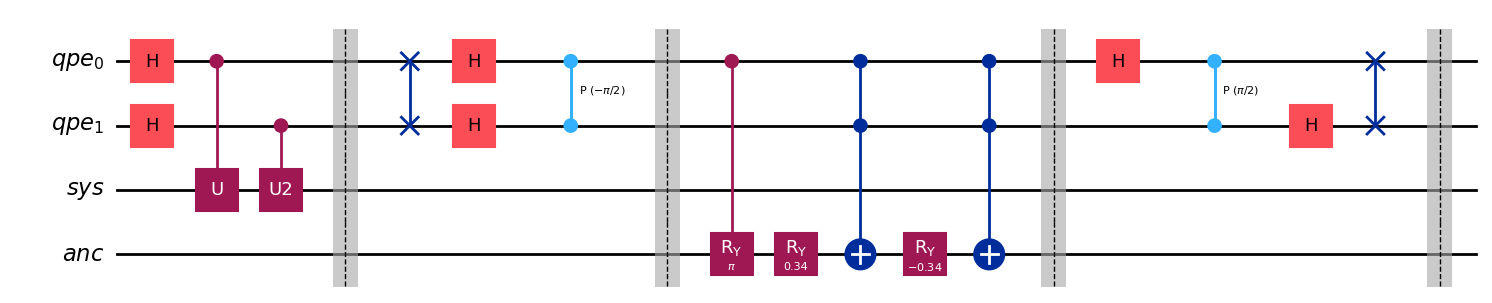

In [28]:
qc.draw('mpl')

In [31]:
vec = state
solution_amp_0 = vec[4]  # |0 0 1>
solution_amp_1 = vec[5]  # |0 1 1>

solution = np.array([solution_amp_0, solution_amp_1])
solution = solution / np.linalg.norm(solution)
solution.real


array([-0.19988235,  0.19988235])

# References
- QFT: https://profmcruz.wordpress.com/wp-content/uploads/2017/08/quantum-computation-and-quantum-information-nielsen-chuang.pdf
- HHL implementation: https://arxiv.org/pdf/2509.16640
- Implemented HHL: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/hhl_tutorial.ipynb
